### LSTM Model with Hyperparameter Tuning

Trial 47 Complete [00h 00m 28s]
val_loss: 0.006434607785195112

Best val_loss So Far: 0.0031510719563812017
Total elapsed time: 00h 22m 11s
Optimal number of units: 256
Optimal dropout rate: 0.1
Optimal learning rate: 0.001
Epoch 1/50
19/19 [==============================] - 2s 43ms/step - loss: 0.0601 - mae: 0.1798 - val_loss: 0.0097 - val_mae: 0.0665
Epoch 2/50
19/19 [==============================] - 1s 35ms/step - loss: 0.0132 - mae: 0.0795 - val_loss: 0.0083 - val_mae: 0.0551
Epoch 3/50
19/19 [==============================] - 1s 32ms/step - loss: 0.0095 - mae: 0.0639 - val_loss: 0.0070 - val_mae: 0.0491
Epoch 4/50
19/19 [==============================] - 1s 37ms/step - loss: 0.0081 - mae: 0.0592 - val_loss: 0.0074 - val_mae: 0.0519
Epoch 5/50
19/19 [==============================] - 1s 36ms/step - loss: 0.0078 - mae: 0.0570 - val_loss: 0.0074 - val_mae: 0.0528
Epoch 6/50
19/19 [==============================] - 1s 33ms/step - loss: 0.0077 - mae: 0.0573 - val_loss: 0.0072 - val_ma

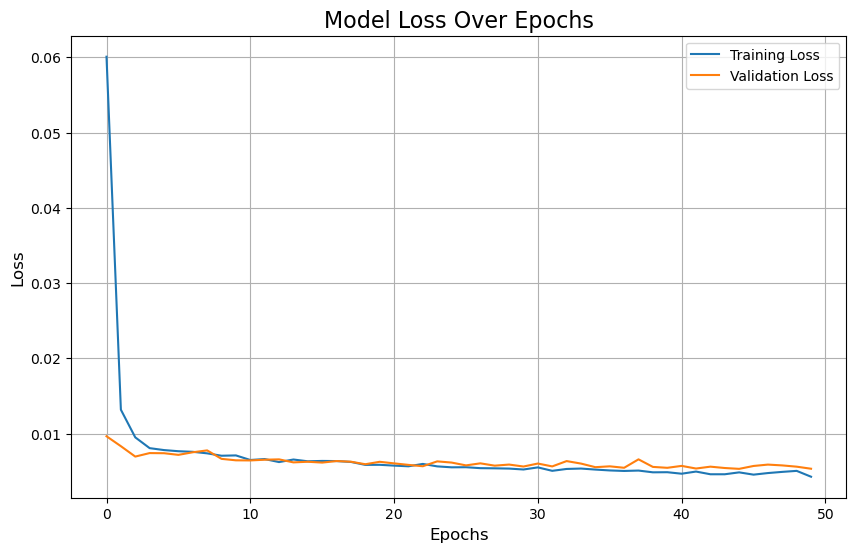

5/5 [==============================] - 0s 6ms/step - loss: 0.0053 - mae: 0.0350
Test Loss: 0.005337002221494913
Test MAE: 0.03497583046555519
Final Training Loss: 0.0042755939066410065
Final Validation Loss: 0.005337002221494913
5/5 [==============================] - 0s 5ms/step


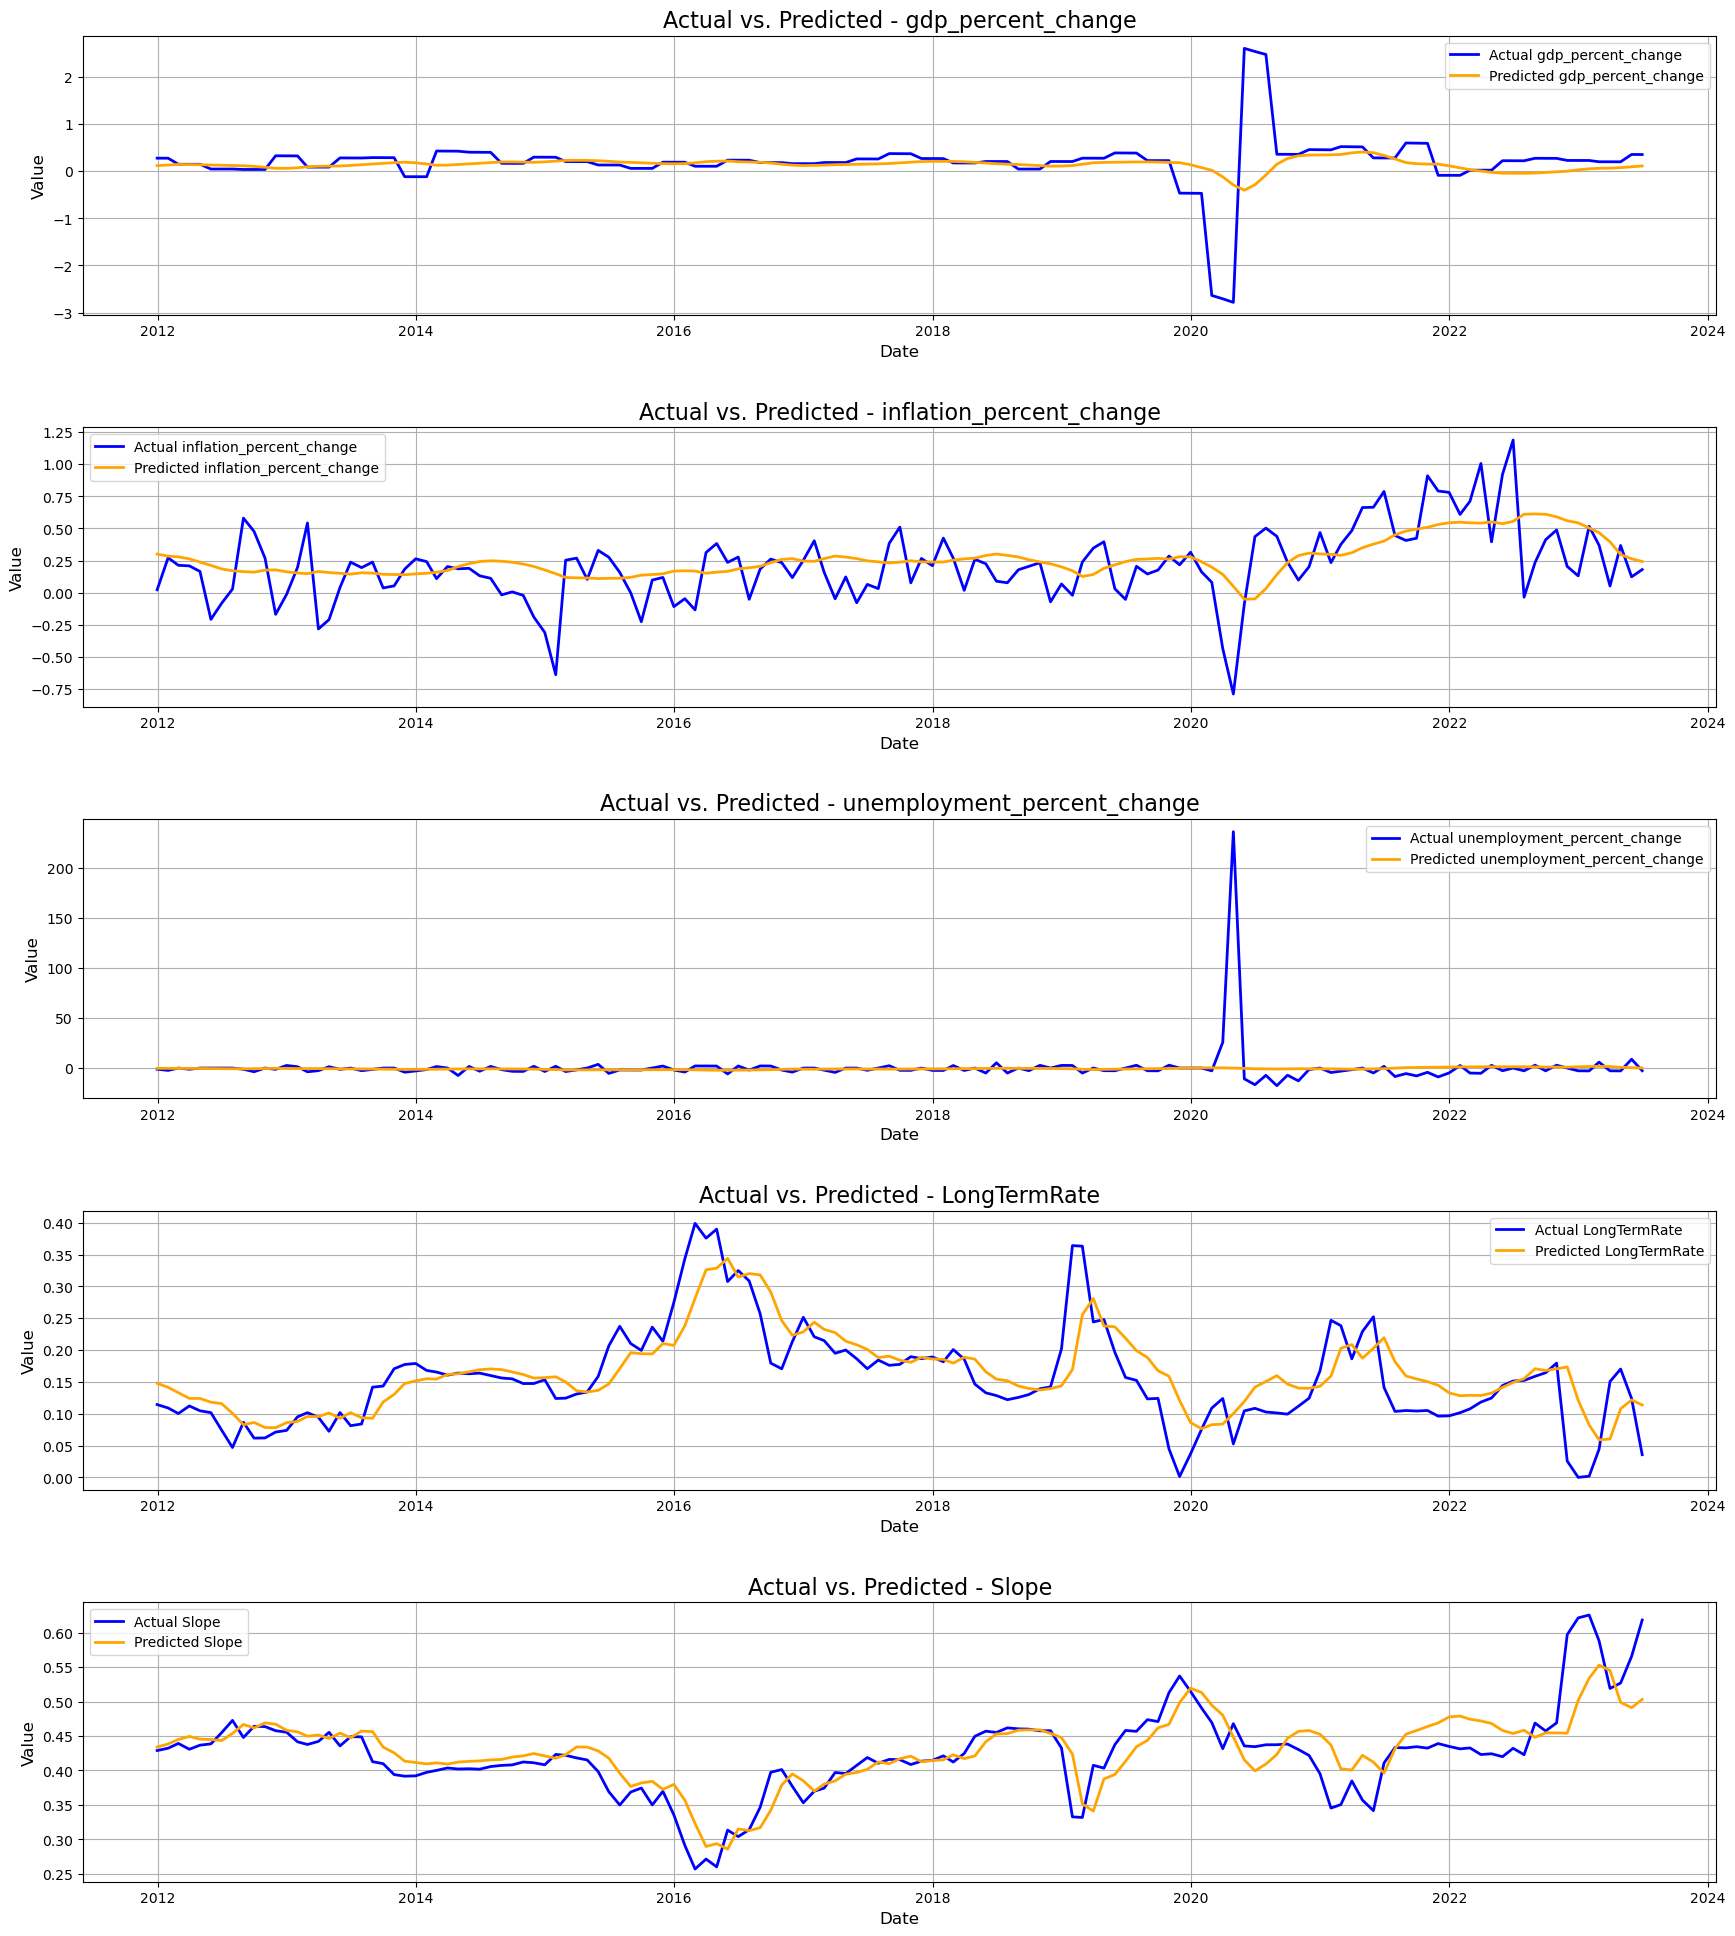

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and preprocess the data
data = pd.read_csv("data/merged_data.csv")
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data.sort_index(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert the data into sequences
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 12  # Use the past 12 months to predict the next month
X, y = create_sequences(scaled_data, look_back)

# Define dividing point between training and testing datasets
split_date = pd.Timestamp('2012-01-01')

# Find the index closest to the split_date
split_index = data.index.get_indexer([split_date], method='nearest')[0]

# Adjust for the look-back period
adjusted_split_index = max(0, split_index - look_back)  # Ensure the index is non-negative

# Split the data into training and testing sets based on the adjusted split index
X_train, X_test = X[:adjusted_split_index], X[adjusted_split_index:]
y_train, y_test = y[:adjusted_split_index], y[adjusted_split_index:]

# Extract corresponding dates for y_test
test_dates = data.index[adjusted_split_index + look_back:]  # Adjust for the look-back

# Ensure the sequential split aligns correctly with the data
print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Testing data: {X_test.shape}, {y_test.shape}")

# Build the LSTM model
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            activation='relu',
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(
        LSTM(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            activation='relu'
        )
    )
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(Dense(y_train.shape[1], activation='linear'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

# Hyperparameter tuning 
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='lstm_random_search'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal number of units: {best_hps.get('units')}")
print(f"Optimal dropout rate: {best_hps.get('dropout_rate')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
test_loss, test_mae = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Final training and validation loss
final_training_loss = history.history['loss'][-1]
final_validation_loss = history.history['val_loss'][-1]
print(f"Final Training Loss: {final_training_loss}")
print(f"Final Validation Loss: {final_validation_loss}")

# Save the trained model
best_model.save("best_lstm_model.h5")

# Predict and inverse transform the results
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Plot actual vs predicted values for each feature
num_features = y_test.shape[1]

plt.figure(figsize=(18, num_features * 4))  
for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.plot(test_dates, y_test_inverse[:, i], label=f'Actual {data.columns[i]}', color='blue', linewidth=2)
    plt.plot(test_dates, predictions[:, i], label=f'Predicted {data.columns[i]}', color='orange', linewidth=2)
    plt.title(f"Actual vs. Predicted - {data.columns[i]}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid()

plt.tight_layout(pad=3.0)  
plt.show()
